## WIS - CDIP Comparisons: Aggregate netCDF Files
Aggregate script does the following:
* Enter start and end dates
* Aggregate individual monthly WIS netCDF files
* Plot WIS output at CDIP buoy locations over date range

### Initialize variables
Enter NDBC/CDIP buoy information and start/end dates

In [2]:
ndbc_id = '44098'             #- 160- jeffrey's Ledge
cdip_id = '160'
buoy_name = 'Jeffreys Ledge'
region = 'Atlantic'

start_date = '20080101'
end_date = '20081231'

### Import Python libraries

In [3]:
import netCDF4
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mat_dates
from datetime import datetime
from dateutil.rrule import rrule, MONTHLY
import dateutil.parser
import time
import calendar
%matplotlib inline

### Define a function to convert date_string (YYYYMMDD) to datetime obj
Note: These individual functions will eventually be compiled into somesort of utils script so we don't have to rewrite them everytime 

In [4]:
#- Define a function to convert date_string (YYYYMMDD) to datetime obj 
def str_datetime(d):
    return (datetime.strptime(d,'%Y%m%d'))
#- utilize functin and convert to datetime objects
start_dt = str_datetime(start_date)
end_dt = str_datetime(end_date)

### Load WIS data from FRF Thredds server
* WIS files are organized by month, need to figure out which files to grab.
* Generate a list of files to process from THREDDS server
* Utilize the xarray library to open and aggregate all relevant netCDF files

In [6]:
#- get a list of months between start and end time as datetime objects
dates = [dt for dt in rrule(MONTHLY, dtstart=start_dt,until=end_dt)]

#- Iterate over the possible months and generate a list of files (fnames)
fnames = []
for dt in dates:
    year = dt.strftime('%Y')	#- '2008'
    month = dt.strftime('%m')	#- '02'
    wis_url = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/wis/'+ \
          region+'/ST'+ndbc_id+'/'+year+'/'
    nc_file = 'WIS-ocean_waves_ST'+ndbc_id+'_'+year+month+'.nc'
    fnames.append(wis_url+nc_file)


The xarray library takes an array of netCDF filenames and compiles them together into a dataset object called 'DS'

In [7]:
#- Use xarray library to merge mulitple netCDF files
DS = xr.open_mfdataset(fnames)

### Use xarray to get values of variables as numpy object

In [8]:
#- Use xarray.values to get values as numpy object
nc_time = DS.time.values
Hs = DS.waveHs.values
Tp = DS.waveTp.values
Dp = DS.waveMeanDirection.values

### Convert unix time to datetime object
Time data are stored as UNIX timestamps (values are in seconds since 01-01-1970 00:00:00). The xarray library convert everything to numpy64 data objects. To be consistent with other code, we convert these to datetime objects.

In [9]:
#- Function to convert numpy64 to datetime
#- https://gist.github.com/blaylockbk/1677b446bc741ee2db3e943ab7e4cabd
def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

#- Now iterate over unix times and convert to datetime objects using function to_datetime()
wave_time = [to_datetime(t) for t in nc_time]

### Plot wave parameters
Utilize matplotlib (python lib) to create a figure with:
* Three subplots (pHs, pTp, pDp) with shared x-axis
* Additional axis parameters/labels/grids for readability

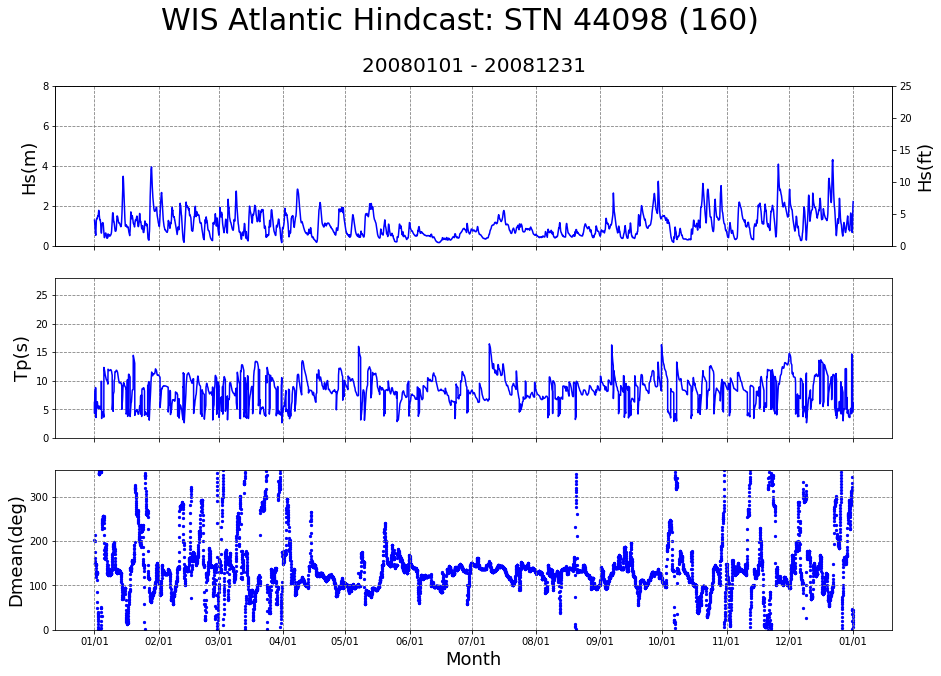

In [12]:
#- Plot wave bulk parameters 
# Create figure and specify subplot orientation (3 rows, 1 column), shared x-axis, and figure size
f, (pHs, pTp, pDp) = plt.subplots(3, 1, sharex=True, figsize=(15,10)) 

# Create 3 stacked subplots for three PARAMETERS (Hs, Tp, Dp)
pHs.plot(wave_time,Hs,'b')
pTp.plot(wave_time,Tp,'b')
pDp.scatter(wave_time,Dp,color='blue',s=5) # Plot Dp variable as a scatterplot, rather than line

#- plot title
plot_title = DS.title+': STN '+ndbc_id+' ('+cdip_id+')'
# Set Titles
plt.suptitle(plot_title, fontsize=30, y=0.99)
plt.title(start_date + " - " + end_date, fontsize=20, y=3.45)


# Set x-axis tick interval to every 5 days
months = mat_dates.MonthLocator(interval=1) 
daysFmt = mat_dates.DateFormatter('%m/%d')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(daysFmt)

# Label x-axis
plt.xlabel('Month', fontsize=18)
# Make a second y-axis for the Hs plot, to show values in both meters and feet
pHs2 = pHs.twinx()

# Set y-axis limits for each plot
pHs.set_ylim(0,8)
pHs2.set_ylim(0,25)
pTp.set_ylim(0,28)
pDp.set_ylim(0,360)

# Label each y-axis
pHs.set_ylabel('Hs(m)', fontsize=18)
pHs2.set_ylabel('Hs(ft)', fontsize=18)
pTp.set_ylabel('Tp(s)', fontsize=18)
pDp.set_ylabel('Dmean(deg)', fontsize=18)

# Plot dashed gridlines
pHs.grid(b=True, which='major', color='gray', linestyle='--')
pTp.grid(b=True, which='major', color='gray', linestyle='--')
pDp.grid(b=True, which='major', color='gray', linestyle='--')
